## Importing libraries

In [64]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from ast import literal_eval

import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stopword = set(stopwords.words('english'))

## Opening csv file and removing redundant ID column

In [65]:
df = pd.read_csv('Covid_Papers.csv')

In [66]:
df.drop("Unnamed: 0", axis =1, inplace = True)
df['abstract'] = df['title'] + ' ' + df['abstract']
df.drop("title", axis =1, inplace = True)

In [67]:
df


,abstract,tags
0,Real-World Experience with COVID-19 Including...,"['Aged', 'Aged, 80 and over', 'Antibodies, Mon..."
1,Successful outcome of pre-engraftment COVID-19...,"['COVID-19*', 'Hematopoietic Stem Cell Transpl..."
2,The impact of COVID-19 on oncology professiona...,"['Burnout, Professional* / epidemiology', 'COV..."
3,ICU admission and mortality classifiers for CO...,"['Bayes Theorem', 'COVID-19*', 'Hospitalizatio..."
4,Clinical evaluation of nasopharyngeal midturb...,"['COVID-19 Testing', 'COVID-19* / diagnosis', ..."
...,...,...
5468,Hypersensitivity Reactions to Vaccines Curren...,"['Anaphylaxis* / chemically induced', 'COVID-1..."
5469,Rooming-in Breastfeeding and Neonatal Follow-...,"['Breast Feeding*', 'COVID-19*', 'Female', 'Fo..."
5470,Acute Abducens Nerve Palsy Following the Secon...,['Abducens Nerve Diseases* / chemically induce...
5471,Planning and Implementing the Protocol for Psy...,"['COVID-19*', 'Delivery of Health Care', 'Huma..."


## Creating helper functions to clean text for later

In [68]:
def remove_punctuation(text):
    
    # punctuations except -  
    punc ='''?!.,:;_—[](){}'"`~|\/@#$%^&+=*'''
    for i in text:
        if i in punc:
            text = text.replace(i, ' ')            
    return text.strip()

def preprocess(text):
    
    # lower casing
    text=text.lower()
    
    # stopword removal
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    
    # lemmatization
    text = [lemmatizer.lemmatize(word) for word in text.split(' ')]
    text = " ".join(text)
    
    # removing words containing only numbers
    text = re.sub(r'\s[0-9]+\s', '', text)
    
    # remove extra spaces
    text = re.sub("\s\s+", " ", text)   
    return text.strip()

In [69]:
df.head()

,abstract,tags
0,Real-World Experience with COVID-19 Including...,"['Aged', 'Aged, 80 and over', 'Antibodies, Mon..."
1,Successful outcome of pre-engraftment COVID-19...,"['COVID-19*', 'Hematopoietic Stem Cell Transpl..."
2,The impact of COVID-19 on oncology professiona...,"['Burnout, Professional* / epidemiology', 'COV..."
3,ICU admission and mortality classifiers for CO...,"['Bayes Theorem', 'COVID-19*', 'Hospitalizatio..."
4,Clinical evaluation of nasopharyngeal midturb...,"['COVID-19 Testing', 'COVID-19* / diagnosis', ..."


In [70]:
df['abstract']=df['abstract'].apply(remove_punctuation)
df['abstract']=df['abstract'].apply(preprocess)

In [71]:
df.loc[1][1]

"['COVID-19*', 'Hematopoietic Stem Cell Transplantation*', 'Humans', 'Immunity, Cellular', 'Pandemics', 'SARS-CoV-2']"

## Making column into string literals for easier computation

In [72]:
df["tags"] = df["tags"].apply(
    lambda x: literal_eval(x)
)
df["tags"].values[:5]

array([list(['Aged', 'Aged, 80 and over', 'Antibodies, Monoclonal, Humanized / therapeutic use*', 'Antibodies, Neutralizing / therapeutic use', 'Antigens, Viral / analysis', 'COVID-19 Testing', 'COVID-19* / diagnosis', 'COVID-19* / therapy', 'Hospitals', 'Humans', 'Middle Aged', 'Retrospective Studies', 'South Dakota']),
       list(['COVID-19*', 'Hematopoietic Stem Cell Transplantation*', 'Humans', 'Immunity, Cellular', 'Pandemics', 'SARS-CoV-2']),
       list(['Burnout, Professional* / epidemiology', 'COVID-19* / epidemiology', 'COVID-19* / psychology', 'Europe / epidemiology', 'Female', 'Health Personnel* / psychology', 'Humans', 'Medical Oncology*', 'Pandemics', 'Societies, Medical']),
       list(['Bayes Theorem', 'COVID-19*', 'Hospitalization', 'Humans', 'Intensive Care Units', 'Retrospective Studies', 'SARS-CoV-2']),
       list(['COVID-19 Testing', 'COVID-19* / diagnosis', 'Humans', 'Nasopharynx', 'SARS-CoV-2*', 'Saliva', 'Specimen Handling'])],
      dtype=object)

## Splitting data into train, val and test

In [73]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(df, test_size=test_split)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

D:\Programming\Anaconda\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [74]:
tags = tf.ragged.constant(train_df["tags"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(tags)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

In [75]:
vocab

['[UNK]',
 'Humans',
 'SARS-CoV-2',
 'COVID-19*',
 'Pandemics',
 'Female',
 'Male',
 'Adult',
 'Middle Aged',
 'Aged',
 'Retrospective Studies',
 'Cross-Sectional Studies',
 'Child',
 'Adolescent',
 'COVID-19* / epidemiology',
 'Animals',
 'COVID-19 / virology',
 'Young Adult',
 'SARS-CoV-2*',
 'Pandemics*',
 'COVID-19 Vaccines',
 'Vaccination',
 'Surveys and Questionnaires',
 'Communicable Disease Control',
 'COVID-19* / prevention &amp; control',
 'COVID-19 / epidemiology*',
 'COVID-19 / epidemiology',
 'Prospective Studies',
 'Risk Factors',
 'Aged, 80 and over',
 'SARS-CoV-2 / immunology*',
 'COVID-19 / prevention &amp; control*',
 'COVID-19 / immunology*',
 'SARS-CoV-2 / isolation &amp; purification',
 'Cohort Studies',
 'Health Personnel',
 'Treatment Outcome',
 'Pandemics / prevention &amp; control',
 'Pregnancy',
 'COVID-19 / immunology',
 'United States',
 'SARS-CoV-2 / genetics',
 'Antibodies, Viral',
 'Infant',
 'COVID-19 / prevention &amp; control',
 'Child, Preschool',
 'U

## Finding good value for max length (using median value)

In [76]:
train_df["abstract"].apply(lambda x: len(x.split(" "))).describe()

count    4925.000000
mean      148.807513
std        49.753408
min        23.000000
25%       117.000000
50%       147.000000
75%       177.000000
max       436.000000
Name: abstract, dtype: float64

## Transforming datasets to later vectorise

In [77]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["tags"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["abstract"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [78]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [79]:
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 10519), dtype=tf.float32, name=None))>

## Creating vocabulary for vectorisation of text and mapping dataset with vectorizer

In [80]:
vocabulary = set()
train_df["abstract"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

45816


In [81]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [82]:
train_dataset.cardinality

<bound method DatasetV2.cardinality of <PrefetchDataset element_spec=(TensorSpec(shape=(None, 45816), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10519), dtype=tf.float32, name=None))>>

## Dataset now ready to be used

In [83]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 45816), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10519), dtype=tf.float32, name=None))>

## Creating the model

In [84]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ] 
    )
    return shallow_mlp_model

In [85]:
epochs = 15

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss= "poisson", optimizer = keras.optimizers.Adam(learning_rate=0.00005), metrics=["categorical_accuracy"], 
)

## Training the model

In [86]:
history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)

Epoch 1/15
39/39 [==============================] - 8s 181ms/step - loss: 0.4207 - categorical_accuracy: 0.0000e+00 - val_loss: 0.2587 - val_categorical_accuracy: 0.0000e+00
Epoch 2/15
39/39 [==============================] - 7s 173ms/step - loss: 0.1247 - categorical_accuracy: 0.4504 - val_loss: 0.0261 - val_categorical_accuracy: 0.4343
Epoch 3/15
39/39 [==============================] - 7s 179ms/step - loss: 0.0162 - categorical_accuracy: 0.9840 - val_loss: 0.0106 - val_categorical_accuracy: 0.4343
Epoch 4/15
39/39 [==============================] - 8s 189ms/step - loss: 0.0097 - categorical_accuracy: 0.9840 - val_loss: 0.0088 - val_categorical_accuracy: 0.4343
Epoch 5/15
39/39 [==============================] - 7s 173ms/step - loss: 0.0085 - categorical_accuracy: 0.9840 - val_loss: 0.0081 - val_categorical_accuracy: 0.4343
Epoch 6/15
39/39 [==============================] - 8s 205ms/step - loss: 0.0080 - categorical_accuracy: 0.9840 - val_loss: 0.0077 - val_categorical_accuracy: 0.4

## Visuallising our training

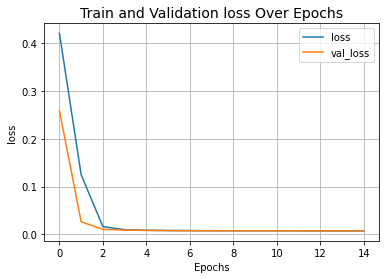

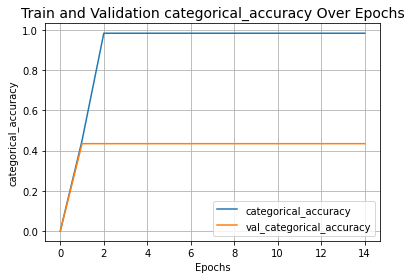

In [87]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

## Test Accuracy:

In [88]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

3/3 [==============================] - 0s 36ms/step - loss: 0.0065 - categorical_accuracy: 0.5109
Categorical accuracy on the test set: 51.09%.


In [126]:
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)
for prob in predicted_probabilities:
    prob[prob > 0.5]

In [125]:
predicted_probabilities[0]

array([1.1708085e-10, 1.0000000e+00, 6.5043950e-01, ..., 8.4617330e-10,
       1.0933418e-08, 3.0173343e-08], dtype=float32)

In [118]:
top_3_labels = [
    x for _, x in sorted(
        zip(predicted_probabilities[i], lookup.get_vocabulary()),
        key=lambda pair: pair[0],
        reverse=True,
    )
]

In [119]:
len(top_3_labels)

10519

## Testing how the model tags data

In [148]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])
top_prob = []

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)
for prob in predicted_probabilities:
    top_prob.append(prob[prob > 0.105])

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in top_prob[i]]
    top_labels = [
        x for _, x in sorted(
            zip(top_prob[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,)]
    top_labels.remove('[UNK]')
    print(f"Predicted Label(s): ({', '.join([label for label in top_labels])})")
    print(" ")

Abstract: b'study investigate covid-19 infection people living ireland scopi seroprevalence study june julybackgroundrobust data sars-cov-2 population seroprevalence supplement surveillance data providing evidence public health action aimto conduct sars-cov-2 population-based seroprevalence survey ireland methodsusing cross-sectional study design selected population sample individual aged 12-69 year county dublin sligo using health service executive primary care reimbursement service database sampling frame sample selected probability proportional general population age-sex distribution simple random sampling within age-sex stratum antibody sars-cov-2 detected using abbott architect sars-cov-2 igg assay confirmed using wantai assay estimated population sars-cov-2 seroprevalence weighted age sex geographic area resultsparticipation rate 3 1 dublin sligo thirty-three specimen detectable sars-cov-2 antibody 9 estimated weighted seroprevalences12 confidence interval ci 05-458 ci 18-1 dubli

## TODO: Add Titles into model, with seperate vectorisation and weights to abstract 
## Stratify our dataset 
## Finetune model (use laxer activation function)

In [143]:
top_labels[0]

'[UNK]'